# Experiment with different classification algorithms

## Plan

### Step 1: Experiment with Different Classification Algorithms
We'll try several classification algorithms and compare their performance. Specifically, we'll experiment with:

- Random Forest
- Support Vector Machine (SVM)
- Gradient Boosting
- XGBoost

### Step 2: Feature Engineering
We'll create interaction features to see if combining some of the features improves the model's performance.

## Baseline

### Set up

In [164]:
import pandas as pd
import joblib
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel

# Load the data
file_path = r"../data/clean/ACME-happinesSurvey2020.parquet"
data = pd.read_parquet(file_path)
target = 'Y'

In [165]:
data_melt = data.melt(id_vars=target, value_vars=data.columns)

### 2: Plot relationships

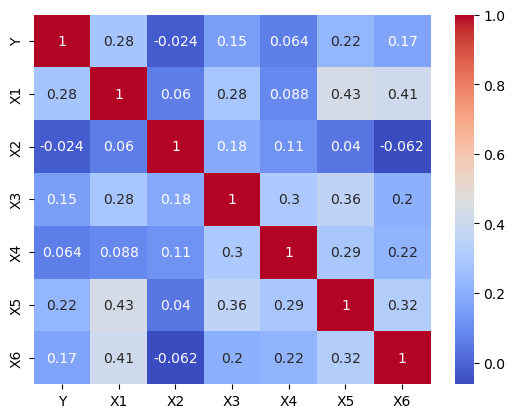

In [166]:
corr = data.corr()  # Calculate the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')  # Create a heatmap
plt.show()  # Show the plot

C:\Users\Guill\AppData\Local\Temp\ipykernel_50932\2225255784.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(


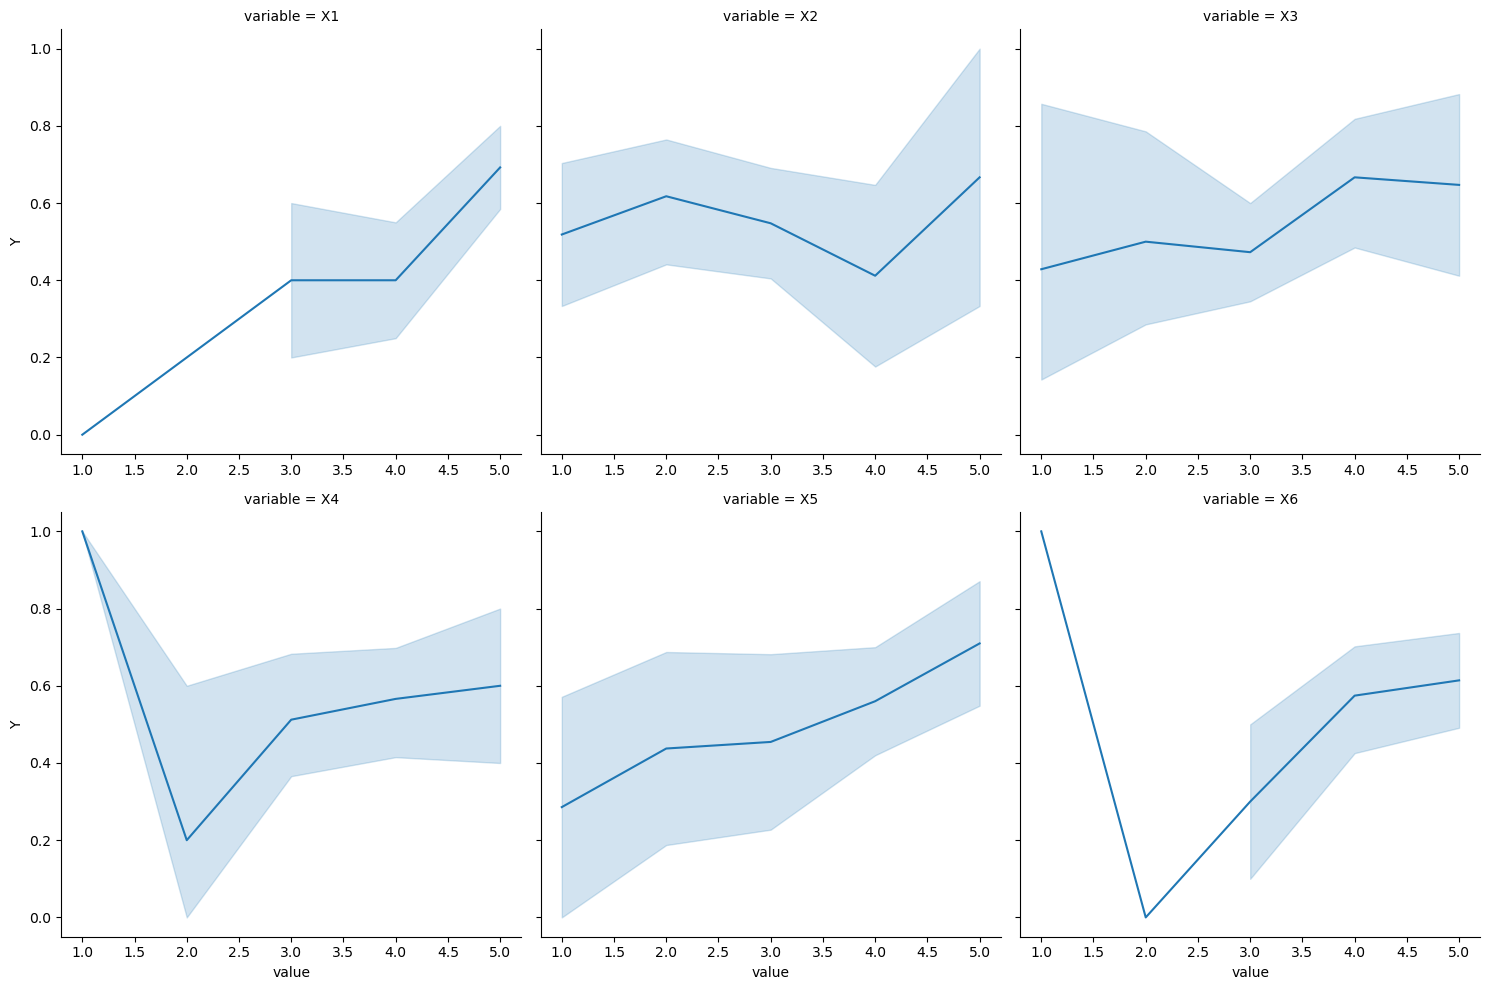

In [167]:
sns.relplot(
    x="value", y=target, col="variable", data=data_melt, facet_kws=dict(sharex=False),
    kind="line", palette="viridis", height=5, aspect=1,
    col_wrap=3

);

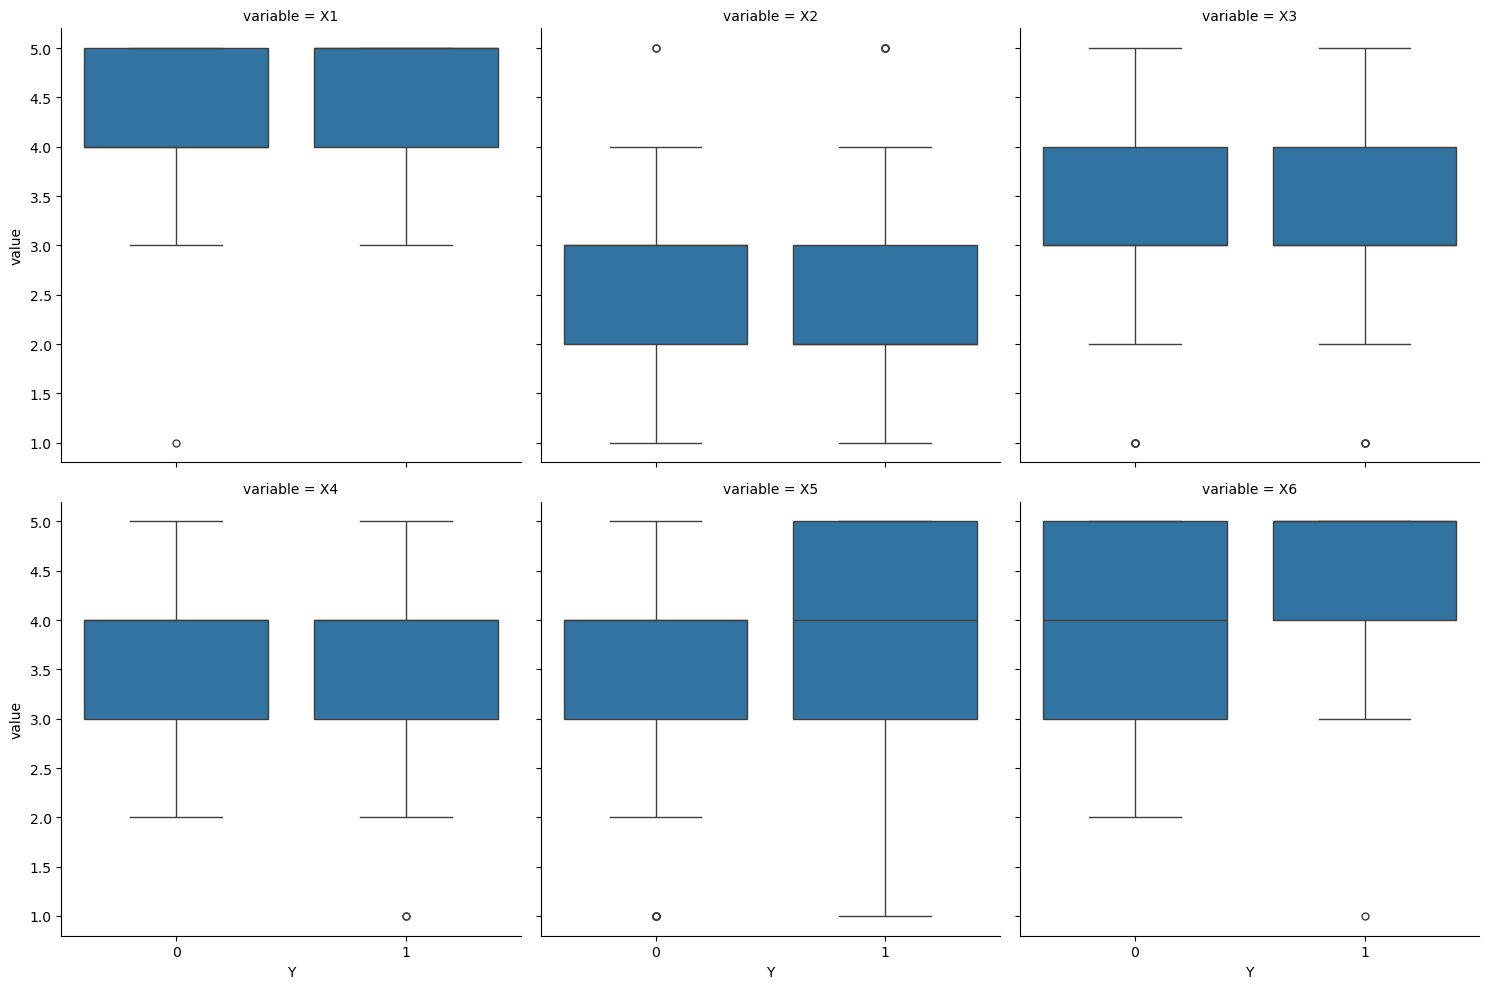

In [168]:
sns.catplot(x=target, y="value", col='variable', data=data_melt, kind="box", col_wrap=3);

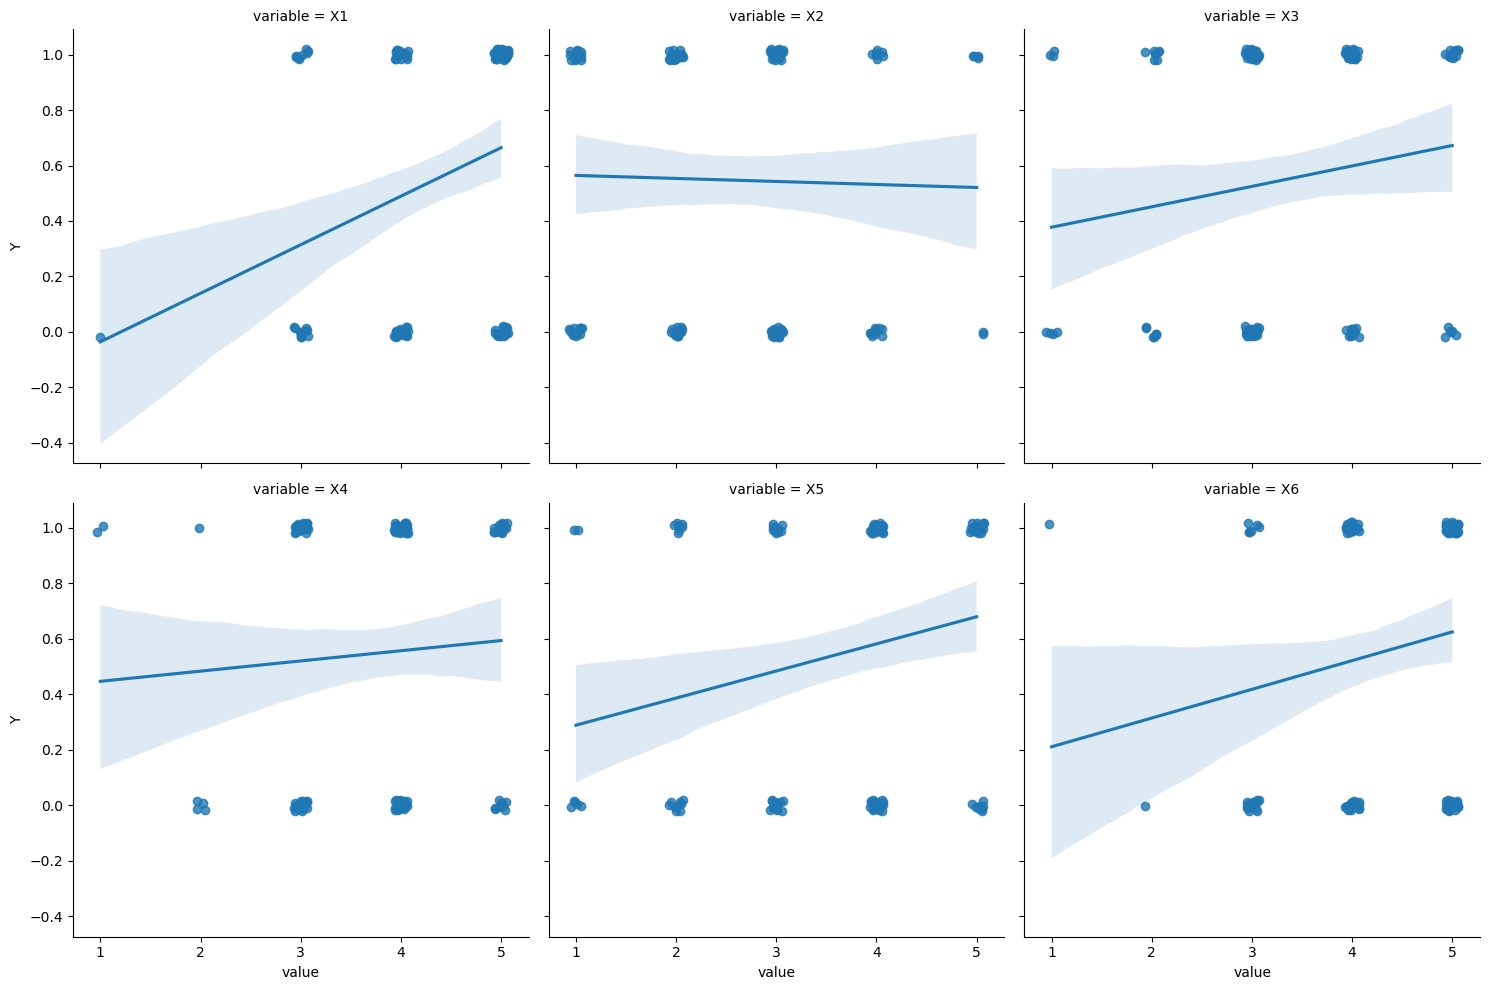

In [169]:
sns.lmplot(y=target, x="value", data=data_melt,
           col='variable', col_wrap=3,
           x_jitter=.07, y_jitter=.02, seed=42);

### 1: Experiment with Different Classification Algorithms

#### Split Data

In [170]:
# Separate features and target
y = data.pop('Y')
X = data

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Models

In [171]:
# Define the models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42, kernel='linear'),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = (accuracy, report)

# Print results
for model_name, (accuracy, report) in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("="*60)

Model: LogisticRegression
Accuracy: 0.46153846153846156
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.33      0.42        15
           1       0.41      0.64      0.50        11

    accuracy                           0.46        26
   macro avg       0.48      0.48      0.46        26
weighted avg       0.49      0.46      0.45        26

Model: SVM
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        15
           1       0.44      0.73      0.55        11

    accuracy                           0.50        26
   macro avg       0.53      0.53      0.49        26
weighted avg       0.55      0.50      0.48        26

Model: RandomForest
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.53      0.82     

#### Feature Importances

In [172]:
# Create a dataset with the feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'LogisticRegression': models["LogisticRegression"].coef_[0],
    'SVM': models["SVM"].coef_[0],
    'RandomForest': models["RandomForest"].feature_importances_,
    'GradientBoosting': models["GradientBoosting"].feature_importances_
})
feature_importances.assign(
    # sum=lambda x: x.iloc[:, 1:].sum(axis=1),
    # avg=lambda x: x.iloc[:, 1:].mean(axis=1),
    sum_tree=lambda x: x.iloc[:, 1:3].sum(axis=1),
    # avg_tree=lambda x: x.iloc[:, 1:3].mean(axis=1),
    # sum_linear=lambda x: x.iloc[:, 3:].sum(axis=1),
    avg_linear=lambda x: x.iloc[:, 3:].mean(axis=1)
    ).sort_values('sum_tree', ascending=False)

,Feature,LogisticRegression,SVM,RandomForest,GradientBoosting,sum_tree,avg_linear
0,X1,0.815221,1.000033,0.169001,0.232032,1.815254,0.738762
5,X6,0.118672,0.000191,0.135711,0.138753,0.118864,0.131109
4,X5,0.050766,0.000020,0.172840,0.211393,0.050786,0.145006
2,X3,-0.056853,-0.000109,0.184256,0.218242,-0.056962,0.115179
3,X4,-0.071886,-0.000084,0.150353,0.079752,-0.071970,0.052711
1,X2,-0.219327,-0.000015,0.187839,0.119828,-0.219343,0.029441


### Permutation feature importance

In [173]:
# Initialize a dictionary to store the permutation importances
permutation_importances = {}

# Loop through each model and calculate permutation importance
for model_name, model in models.items():
    # Calculate the permutation importance
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Store the importance in the dictionary
    permutation_importances[model_name] = result.importances_mean

# Create a DataFrame to organize and display the results
permutation_importances_df = pd.DataFrame(permutation_importances, index=X.columns)

# Add the sum and average of the importances across models
permutation_importances_df['sum'] = permutation_importances_df.sum(axis=1)
permutation_importances_df['avg'] = permutation_importances_df.mean(axis=1)

# Sort the DataFrame by the sum of importances
permutation_importances_df = permutation_importances_df.sort_values('sum', ascending=False)

# Display the DataFrame
permutation_importances_df

,LogisticRegression,SVM,RandomForest,GradientBoosting,sum,avg
X1,-3.461538e-02,-0.003846,0.061538,0.169231,0.192308,0.076923
X3,-3.846154e-03,-0.023077,0.061538,-0.015385,0.019231,0.007692
X5,1.665335e-17,0.003846,-0.023077,0.034615,0.015385,0.006154
X4,-1.538462e-02,0.011538,0.003846,-0.015385,-0.015385,-0.006154
X6,-3.846154e-03,0.015385,-0.042308,-0.065385,-0.096154,-0.038462
X2,-4.615385e-02,0.000000,-0.023077,-0.046154,-0.115385,-0.046154


### Permutation importance Interpretation:

- **X1** stands out as the most important feature overall, with a positive contribution, particularly in tree-based models.
- **X2** and **X6** seem to have a negative impact across the models, indicating that they might not be as useful and could potentially be candidates for removal or further investigation.
- **X3** and **X5** have minor positive impacts, but their overall influence is relatively low compared to X1.
- **X4** seems to have a negligible impact overall, with a slight negative influence.

> **Negative Coefficient** (in models like Logistic Regression or SVM): Indicates a negative effect on the target variable.
>
> **Negative Importance** (especially in permutation importance): Could indicate the feature is harmful or irrelevant to the model’s performance.

### 4: Feature Engineering: Create interaction features

In [174]:
# Feature Engineering: Create interaction features
poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train and evaluate each model with interaction features
results_poly = {}
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results_poly[name] = (accuracy, report)

# Print results for models with interaction features
for model_name, (accuracy, report) in results_poly.items():
    print(f"Model with Interaction Features: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("="*60)

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model with Interaction Features: LogisticRegression
Accuracy: 0.5769230769230769
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.50      0.73      0.59        11

    accuracy                           0.58        26
   macro avg       0.60      0.60      0.58        26
weighted avg       0.62      0.58      0.57        26

Model with Interaction Features: SVM
Accuracy: 0.5769230769230769
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.50      0.73      0.59        11

    accuracy                           0.58        26
   macro avg       0.60      0.60      0.58        26
weighted avg       0.62      0.58      0.57        26

Model with Interaction Features: RandomForest
Accuracy: 0.5384615384615384
Classification Report:
              precision    recall  f1-score   support



#### Feature importances with interaction terms

In [175]:
# Create a dataset with the feature importances
column_names_poly=poly.get_feature_names_out(X_train.columns)

feature_importances_poly = pd.DataFrame({
    'Feature': column_names_poly,
    'LogisticRegression': models["LogisticRegression"].coef_[0],
    'SVM': models["SVM"].coef_[0],
    'RandomForest': models["RandomForest"].feature_importances_,
    'GradientBoosting': models["GradientBoosting"].feature_importances_
}).set_index('Feature')
feature_importances_poly = feature_importances_poly.assign(
    # sum=lambda x: x.iloc[:, 1:].sum(axis=1),
    # avg=lambda x: x.iloc[:, 1:].mean(axis=1),
    sum_tree=lambda x: x.iloc[:, 1:3].sum(axis=1),
    avg_tree=lambda x: x.iloc[:, 1:3].mean(axis=1),
    # sum_linear=lambda x: x.iloc[:, 3:].sum(axis=1),
    avg_linear=lambda x: x.iloc[:, 3:].mean(axis=1)
    ).sort_values('sum_tree', ascending=False)

feature_importances_poly

,LogisticRegression,SVM,RandomForest,GradientBoosting,sum_tree,avg_tree,avg_linear
Feature,,,,,,,
X1^2 X3,0.712149,1.034290,0.012296,0.016588,1.046586,0.523293,0.528822
X2 X3 X4,0.450102,0.868349,0.018533,0.072054,0.886882,0.443441,0.467459
X2^2 X5,0.659692,0.857638,0.017582,0.036315,0.875220,0.437610,0.449715
X1 X2 X3,0.606734,0.731594,0.020067,0.040352,0.751662,0.375831,0.389282
X3 X4 X5,0.884925,0.704564,0.011275,0.009262,0.715839,0.357920,0.361007
...,...,...,...,...,...,...,...
X2^2 X3,-0.382194,-0.612049,0.015249,0.003905,-0.596800,-0.298400,-0.297098
X1 X2^2,-0.408883,-0.638906,0.008979,0.001576,-0.629927,-0.314963,-0.314438
X3 X4 X6,-0.361748,-0.822198,0.010269,0.012083,-0.811929,-0.405965,-0.401937


#### Permutation feature importance with interactions

In [176]:
# Initialize a dictionary to store the permutation importance
permutation_importances_poly = {}

# Loop through each model and calculate permutation importance
for model_name, model in models.items():
    # Calculate the permutation importance
    result = permutation_importance(
        model, X_test_poly, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Store the importance in the dictionary
    permutation_importances_poly[model_name] = result.importances_mean

# Create a DataFrame to organize and display the results
permutation_importances_poly_df = pd.DataFrame(permutation_importances_poly, index=column_names_poly)

# Reorder the columns to match the desired order
permutation_importances_poly_df = permutation_importances_poly_df[["LogisticRegression", "SVM", "RandomForest", "GradientBoosting"]]

# Add the sum and average of the importances across models
permutation_importances_poly_df = permutation_importances_poly_df.assign(
    sum_tree=lambda x: x.iloc[:, 2:4].sum(axis=1),  # Sum of tree-based models (RandomForest and GradientBoosting)
    avg_tree=lambda x: x.iloc[:, 2:4].mean(axis=1),  # Average of tree-based models (RandomForest and GradientBoosting)
    avg_linear=lambda x: x.iloc[:, 0:2].mean(axis=1)  # Average of linear models (LogisticRegression and SVM)
).sort_values('avg_tree', ascending=False)

permutation_importances_poly_df

,LogisticRegression,SVM,RandomForest,GradientBoosting,sum_tree,avg_tree,avg_linear
X1^2 X3,0.188462,0.192308,0.011538,0.057692,0.069231,0.034615,1.903846e-01
X1 X3 X6,-0.046154,-0.053846,0.003846,0.053846,0.057692,0.028846,-5.000000e-02
X3 X5 X6,-0.073077,0.073077,0.019231,0.038462,0.057692,0.028846,-4.857226e-17
X1 X6,0.057692,0.096154,0.003846,0.050000,0.053846,0.026923,7.692308e-02
X1^2 X5,-0.073077,-0.076923,0.000000,0.034615,0.034615,0.017308,-7.500000e-02
...,...,...,...,...,...,...,...
X1 X2 X4,0.150000,0.126923,-0.003846,-0.034615,-0.038462,-0.019231,1.384615e-01
X1 X2 X6,0.169231,0.161538,0.000000,-0.042308,-0.042308,-0.021154,1.653846e-01
X5 X6^2,0.238462,0.246154,0.000000,-0.046154,-0.046154,-0.023077,2.423077e-01
X2 X3 X5,-0.050000,-0.015385,0.000000,-0.050000,-0.050000,-0.025000,-3.269231e-02


### Preselection

,LogisticRegression,SVM,RandomForest,GradientBoosting,sum_tree,avg_tree,avg_linear
X1^2 X3,0.900610,1.226598,0.023834,0.074280,1.115816,0.557908,0.719207
X2^2 X5,0.798154,0.988407,0.017582,0.055546,0.894451,0.447226,0.584331
X2 X3 X4,0.634717,1.041426,0.041610,0.048978,0.886882,0.443441,0.646305
X1 X2 X3,0.756734,0.885440,0.020067,0.001891,0.713200,0.356600,0.541205
X5^2 X6,0.841589,0.720815,0.015582,0.005069,0.490243,0.245122,0.487196
X2 X6,0.388707,0.569074,0.010099,0.003107,0.486865,0.243433,0.325237
X2^2 X6,0.372188,0.577086,0.014391,0.001406,0.468400,0.234200,0.359669
X1 X2,0.307475,0.536574,0.010193,0.001167,0.454459,0.227230,0.308388
X1 X4^2,0.766957,0.615373,0.020059,0.020041,0.427739,0.213870,0.417345
X3 X4^2,0.438275,0.594695,0.026005,0.026254,0.416853,0.208427,0.408204


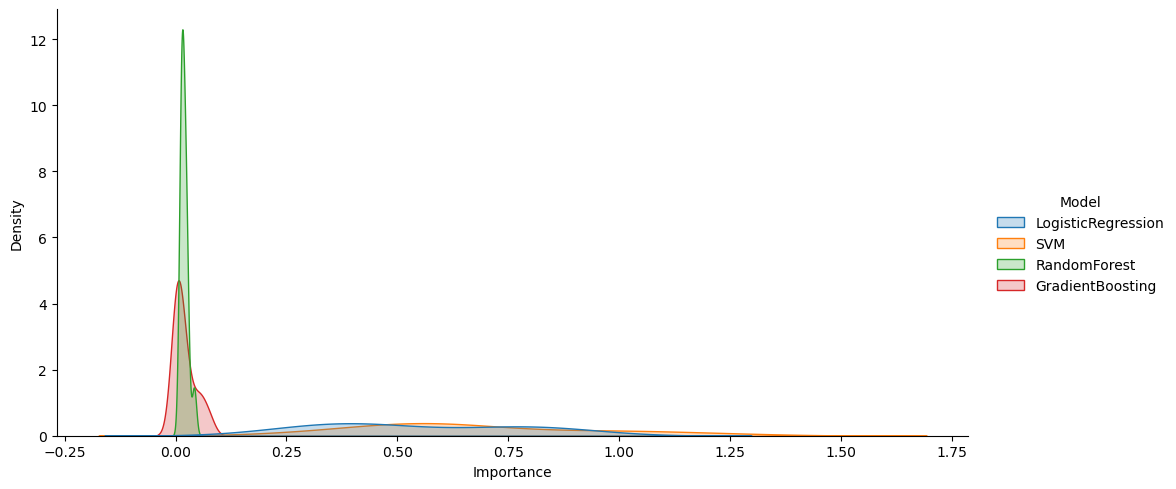

In [201]:
feature_relevance = (feature_importances_poly + permutation_importances_poly_df).sort_values('sum_tree', ascending=False)

# Take absolute values for the linear related columns
feature_relevance['LogisticRegression'] = feature_relevance['LogisticRegression'].abs()
feature_relevance['SVM'] = feature_relevance['SVM'].abs()
feature_relevance['avg_linear'] = feature_relevance['avg_linear'].abs()

# display(sns.displot(feature_relevance, x='sum_tree', kind='kde', fill=True, aspect=2))

# Calculate the 25th percentile (quantile 0.25) for each column
quantiles = feature_relevance.quantile(0.30)

# Filter out rows below the 25th percentile in any column
filtered_df = feature_relevance[(feature_relevance >= quantiles).all(axis=1)]

# Display the filtered DataFrame
display(filtered_df)

# Melt filtered_df
filtered_df_melt = filtered_df.melt(value_vars=['LogisticRegression', 'SVM', 'RandomForest', 'GradientBoosting'],
                                     var_name='Model', value_name='Importance', ignore_index=False)

# plot the distribution of filtered_df_melt separating the models by color
sns.displot(filtered_df_melt, x='Importance', hue='Model', kind='kde', fill=True, aspect=2)

In [222]:
# Display the filtered DataFrame
df_train_poly = pd.DataFrame(X_train_poly,
                columns=column_names_poly)[filtered_df.index]

df_test_poly = pd.DataFrame(X_test_poly,
             columns=column_names_poly)[filtered_df.index]


### 3. Feature Selection with RFE and Tree-Based Importance

- **Recursive Feature Elimination (RFE)**: We'll use RFE to select the most relevant features by recursively considering smaller sets of features and ranking them based on their importance.
- **Feature Importance from Tree-Based Models**: Tree-based models like Random Forest or XGBoost can provide feature importance scores that we can use to select a subset of the most important features.

#### A. Recursive Feature Elimination (RFE)

We'll use RFE with one of the classifiers, such as Logistic Regression or Random Forest, to select the most important features.

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd

# Initialize Logistic Regression
lr = LogisticRegression(max_iter=10_000, random_state=42)

# Apply RFE
rfe = RFE(estimator=lr, n_features_to_select=10, step=1)
rfe.fit(df_train_poly, y_train)

# Get the support and ranking of the features
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

# Create a DataFrame with the feature names and their RFE ranking
rfe_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'RFE Ranking': rfe_ranking
})

# Filter the DataFrame to show only the selected features (those with RFE ranking = 1)
selected_features_df = rfe_df[rfe_support].set_index('Feature')

# Display the DataFrame with selected features and their rankings
print(selected_features_df)


          RFE Ranking
Feature              
X1^2 X3             1
X2^2 X5             1
X2 X3 X4            1
X1 X2 X3            1
X2 X6               1
X2^2 X6             1
X4^2 X5             1
X2 X4 X6            1
X1 X2 X5            1
X4 X5 X6            1


#### **B. Chi2**

Using Chi2 for feature selection

In [247]:
from sklearn.feature_selection import chi2

# Assuming df_train_poly and y_train are your features and labels
chi2_scores, p_values = chi2(df_train_poly, y_train)

# Create a DataFrame to display Chi-square scores
chi2_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
})

# Sort the DataFrame by the Chi2 score in descending order
chi2_df = chi2_df.sort_values(by='Chi2 Score', ascending=False)

# Display the Chi2 scores
print(chi2_df)

     Feature  Chi2 Score       p-value
0    X1^2 X3   97.628480  5.047274e-23
4    X5^2 X6   42.562604  6.845572e-11
13  X4 X5 X6   36.231112  1.752503e-09
8    X1 X4^2   23.375670  1.332533e-06
12  X1 X2 X5   18.009682  2.197843e-05
10   X4^2 X5   12.551467  3.958953e-04
6    X2^2 X6    7.749154  5.373771e-03
9    X3 X4^2    3.007905  8.285930e-02
2   X2 X3 X4    1.783955  1.816644e-01
3   X1 X2 X3    0.766880  3.811838e-01
5      X2 X6    0.331457  5.648026e-01
11  X2 X4 X6    0.245657  6.201498e-01
7      X1 X2    0.209818  6.469099e-01
1    X2^2 X5    0.207030  6.491053e-01


In [248]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(df_train_poly, y_train)

# Use SelectFromModel to select features
selector = SelectFromModel(rf, threshold='mean')  # You can adjust the threshold as needed
selector.fit(df_train_poly, y_train)

# Get the selected features
selected_features = df_train_poly.columns[(selector.get_support())]

# Create a DataFrame to show selected features
selected_features_df = pd.DataFrame({
    'Feature': selected_features
})

# Display the selected features
print(selected_features_df)

    Feature
0   X1^2 X3
1   X2^2 X5
2  X2 X3 X4
3   X5^2 X6
4   X3 X4^2
5  X2 X4 X6


In [243]:
# Calculate the mutual information for each feature in the training set
from sklearn.feature_selection import mutual_info_classif


mutual_info = mutual_info_classif(df_train_poly, y_train, random_state=42)

# Create a DataFrame to display the mutual information scores
mutual_info_s = pd.Series(
    data = mutual_info,
    index = df_train_poly.columns
).rename('Mutual Information')
mutual_info_s[mutual_info_s>0].sort_index(ascending=False)

X5^2 X6     0.037225
X4 X5 X6    0.011790
X3 X4^2     0.027024
X2^2 X5     0.080425
X2 X4 X6    0.003131
X2 X3 X4    0.016335
X1^2 X3     0.069184
X1 X4^2     0.004442
X1 X2 X5    0.006607
X1 X2       0.047204
Name: Mutual Information, dtype: float64

### 3: Hyperparameter Tuning for multiple models

In [ ]:
# RFE selected features
rfe_indices = np.where(rfe.support_)[0]  # Indices of selected features by RFE

# RFC selected features
rfc_importances = rf.feature_importances_
rfc_indices = np.argsort(rfc_importances)[-10:]  # Indices of top 10 important features by RFC

# Concatenate and get unique indices
combined_indices = np.unique(np.concatenate([rfe_indices, rfc_indices]))

# Sort the combined indices (optional, if you want the features in order)
combined_indices.sort()

print(f"Combined unique feature indices: {combined_indices}")

X_train_poly_selected = X_train_poly[:, combined_indices]
X_test_poly_selected = X_test_poly[:, combined_indices]


# Export as parquet
# Append X_train_poly_selected + y_train
train_data = np.hstack((X_train_poly_selected, y_train.values.reshape(-1, 1)))

# Append X_test_poly_selected + y_test
test_data = np.hstack((X_test_poly_selected, y_test.values.reshape(-1, 1)))
                      
# Convert to DataFrame
pd.DataFrame(train_data, columns=[f"f{i}" for i in range(X_train_poly_selected.shape[1])] + ['Y']).to_parquet("../data/clean/train.parquet", index=False)  # train_df
pd.DataFrame(test_data, columns=[f"f{i}" for i in range(X_test_poly_selected.shape[1])] + ['Y']).to_parquet("../data/clean/test.parquet", index=False)  # test_df

Combined unique feature indices: [ 6  8 11 18 19 25 26 29 34 35 41 47 50 55 56 59 61 72 82]


In [ ]:
from tqdm import tqdm

# Hyperparameter Tuning for multiple models
tuning_params = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }
}
best_models = {}
for name, model in models.items():
    display(Markdown(f"#### Tuning hyperparameters for {name}..."))
    grid_search = GridSearchCV(estimator=model, param_grid=tuning_params[name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_poly_selected, y_train)
    best_models[name] = grid_search.best_estimator_

# Evaluate the best models
for name, best_model in tqdm(best_models.items()):
    y_pred = best_model.predict(X_test_poly_selected)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Best {name} Model")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("Best Parameters:", best_model.get_params())
    print("="*60)

#### Tuning hyperparameters for LogisticRegression...

Fitting 5 folds for each of 6 candidates, totalling 30 fits


#### Tuning hyperparameters for RandomForest...

Fitting 5 folds for each of 108 candidates, totalling 540 fits


#### Tuning hyperparameters for SVM...

Fitting 5 folds for each of 6 candidates, totalling 30 fits


#### Tuning hyperparameters for GradientBoosting...

Fitting 5 folds for each of 27 candidates, totalling 135 fits


100%|██████████| 4/4 [00:00<00:00, 95.81it/s]

Best LogisticRegression Model
Accuracy: 0.7692307692307693
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.73      0.73      0.73        11

    accuracy                           0.77        26
   macro avg       0.76      0.76      0.76        26
weighted avg       0.77      0.77      0.77        26

Best Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best RandomForest Model
Accuracy: 0.5384615384615384
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54     

### 4: Cross-Validation for the best models

In [ ]:
# Cross-Validation for the best models
for name, best_model in best_models.items():
    cv_scores = cross_val_score(best_model, X, y, cv=5)
    print(f"Cross-Validation Accuracy for {name}: {cv_scores.mean()} ± {cv_scores.std()}")

# Save the best models
# date and time

date_time = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

for name, best_model in best_models.items():
    joblib.dump(best_model, f'../models/best_{name}_model_{date_time}.pkl')

Cross-Validation Accuracy for LogisticRegression: 0.5636923076923077 ± 0.0862504952391236
Cross-Validation Accuracy for RandomForest: 0.6427692307692308 ± 0.14761664728685928
Cross-Validation Accuracy for SVM: 0.54 ± 0.11865917579353062
Cross-Validation Accuracy for GradientBoosting: 0.5156923076923077 ± 0.06963913746921066


The best model is Random forest with 60% Cross-Validation score